# ONNX Runtime部署-摄像头和视频-中文

**目标**：使用 ONNX Runtime 推理引擎，载入 ImageNet 预训练图像分类 onnx 模型，预测摄像头实时画面。

**参考**：https://space.bilibili.com/1900783  

**注意事项**：此代码需要在连接摄像头的本地运行，不能在GPU云平台运行。

### （1）**工具安装**

In [24]:
import os

import cv2
import numpy as np
import pandas as pd

import time
from tqdm import tqdm # 进度条

import torch
import torch.nn.functional as F
from torchvision import transforms

import onnxruntime

from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 下载中文字体文件，直接点击链接下载。
# 下载到“素材文件”中。
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf

In [25]:
# 导入中文字体，指定字体大小
font = ImageFont.truetype("./素材文件/SimHei.ttf", 32)

### （1）**载入 onnx 模型，获取 ONNX Runtime 推理器**

In [26]:
ort_session = onnxruntime.InferenceSession("ResNet18_ImageNet.onnx")

### （2）**载入ImageNet1000图像分类标签**

In [27]:
df = pd.read_csv("./素材文件/imagenet_class_index.csv")
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row["ID"]] = row["Chinese"]

### （3）**预处理**

In [29]:
# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

### （4）摄像头拍摄单帧画面

(480, 640, 3)


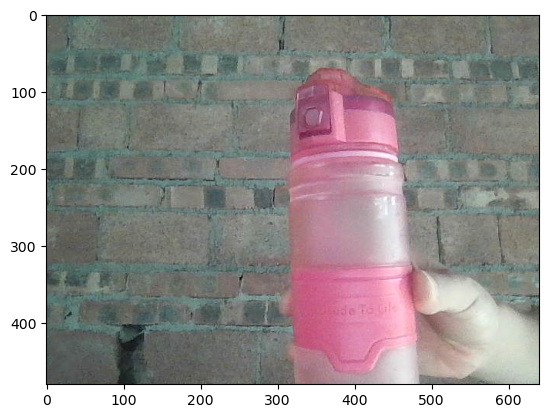

In [52]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

# 拍照
time.sleep(2)  # 运行本代码后等几秒拍照

# 从摄像头捕获一帧画面
success, img_bgr = cap.read()

# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

# 显示拍摄的图片
print(img_bgr.shape)
plt.imshow(img_bgr[:, :, ::-1])
plt.show()

### （5）**图像转为RGB的Pillow格式**

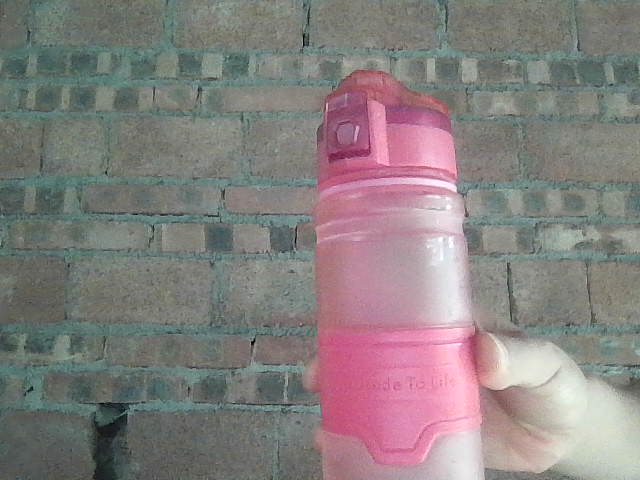

In [53]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)
img_pil

**增加图像维度**

In [54]:
input_img = test_transform(img_pil)
input_tensor = input_img.unsqueeze(0).numpy()
input_tensor.shape

(1, 3, 256, 256)

### （6）**ONNX Runtime推理预测**

In [55]:
# onnx runtime 输入
ort_inputs = {"input": input_tensor}

# onnx runtime 输出
pred_logits = ort_session.run(["output"], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

pred_logits.shape

torch.Size([1, 1000])

**预测结果**

In [56]:
# 对 logit 分数做 softmax 运算
pred_softmax = F.softmax(pred_logits, dim=1)
pred_softmax.shape

torch.Size([1, 1000])

**解析top-n预测结果的类别和置信度**

In [57]:
n = 3
top_n = torch.topk(pred_softmax, n)  # 取置信度最大的 n 个结果

confs = top_n[0].cpu().detach().numpy().squeeze()
confs

array([0.2531613 , 0.09896614, 0.09506559], dtype=float32)

In [58]:
pred_ids = top_n[1].cpu().detach().numpy().squeeze()
pred_ids

array([898, 585, 463], dtype=int64)

### （7）**在图像上用中文写类别**

In [67]:
# 由于这里写中文的功能包含到下面process_frame()函数中，所以注释掉。
"""
draw = ImageDraw.Draw(img_pil) 

for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    
    # 写中文：文字坐标，中文字符串，字体，rgba颜色
    text = '{:<15} {:>.3f}'.format(pred_class, confs[i]) # 中文字符串
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
    
img_rgb = np.array(img_pil) # PIL 转 array

plt.imshow(img_rgb)
plt.show()
"""

"\ndraw = ImageDraw.Draw(img_pil) \n\nfor i in range(len(confs)):\n    pred_class = idx_to_labels[pred_ids[i]]\n    \n    # 写中文：文字坐标，中文字符串，字体，rgba颜色\n    text = '{:<15} {:>.3f}'.format(pred_class, confs[i]) # 中文字符串\n    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))\n    \nimg_rgb = np.array(img_pil) # PIL 转 array\n\nplt.imshow(img_rgb)\nplt.show()\n"

In [68]:
# 处理帧函数
def process_frame(img_bgr):

    # 记录该帧开始处理的时间
    start_time = time.time()

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # BGR转RGB
    img_pil = Image.fromarray(img_rgb)  # array 转 PIL

    ## 预处理
    input_img = test_transform(img_pil)  # 预处理
    input_tensor = input_img.unsqueeze(0).numpy()

    ## onnx runtime 预测
    ort_inputs = {"input": input_tensor}  # onnx runtime 输入
    pred_logits = ort_session.run(["output"], ort_inputs)[0]  # onnx runtime 输出
    pred_logits = torch.tensor(pred_logits)
    pred_softmax = F.softmax(pred_logits, dim=1)  # 对 logit 分数做 softmax 运算

    ## 解析图像分类预测结果
    n = 3
    top_n = torch.topk(pred_softmax, n)  # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze()  # 解析出类别
    confs = top_n[0].cpu().detach().numpy().squeeze()  # 解析出置信度

    ## 在图像上写中文
    draw = ImageDraw.Draw(img_pil)
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]

        # 写中文：文字坐标，中文字符串，字体，rgba颜色
        text = "{:<15} {:>.3f}".format(pred_class, confs[i])  # 中文字符串
        draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))

    img_rgb = np.array(img_pil)  # PIL 转 array
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)  # RGB转BGR

    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1 / (end_time - start_time)
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img_bgr = cv2.putText(
        img_bgr,
        "FPS  " + str(int(FPS)),
        (50, 80),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 0, 255),
        4,
        cv2.LINE_AA,
    )
    return img_bgr

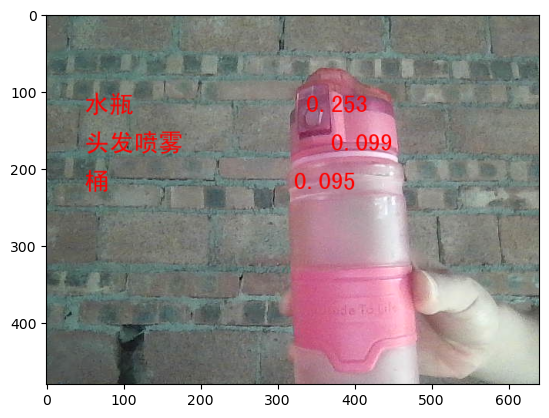

In [69]:
# 如果要修改字体，修改之后重新采集图像并执行此函数，不然会叠加在一张图像上。
process_frame(img_bgr)
plt.imshow(img_rgb)
plt.show()

### （8）**识别摄像头实时获取的图像（模板）**  
__注意__：在代码中设置了在英文输入法下按'q'退出。

In [66]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():

    # 获取画面
    success, frame = cap.read()

    if not success:  # 如果获取画面不成功，则退出
        print("获取画面不成功，退出")
        break

    ## 逐帧处理
    frame = process_frame(frame)

    # 展示处理后的三通道图像
    cv2.imshow("my_window", frame)

    key_pressed = cv2.waitKey(60)  # 每隔多少毫秒毫秒，获取键盘哪个键被按下
    # print('键盘上被按下的键：', key_pressed)

    if key_pressed in [ord("q"), 27]:  # 按键盘上的q或esc退出（在英文输入法下）
        break

# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

### （9）__识别视频中的图像（模板）__

In [70]:
import cv2
import numpy as np
import time
from tqdm import tqdm

# 视频逐帧处理代码模板
# 不需修改任何代码，只需定义process_frame函数即可


def generate_video(input_path="./素材文件/video_4.mp4"):
    """
    识别视频中每一帧图像的函数
    """
    filehead = input_path.split("/")[-1]
    output_path = "./素材文件/中文_out_" + filehead

    print("视频开始处理", input_path)

    # 获取视频总帧数
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while cap.isOpened():
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print("视频总帧数为", frame_count)

    # cv2.namedWindow('Crack Detection and Measurement Video Processing')
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(
        output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1]))
    )

    # 进度条绑定视频总帧数
    with tqdm(total=frame_count - 1) as pbar:
        try:
            while cap.isOpened():
                success, frame = cap.read()
                if not success:
                    break

                # 处理帧
                # frame_path = './temp_frame.png'
                # cv2.imwrite(frame_path, frame)
                try:
                    frame = process_frame(frame)
                except:
                    print("报错！")
                    pass

                if success == True:
                    # cv2.imshow('Video Processing', frame)
                    out.write(frame)

                    # 进度条更新一帧
                    pbar.update(1)

                # if cv2.waitKey(1) & 0xFF == ord('q'):
                # break
        except:
            print("中途中断")
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print("视频已保存", output_path)

In [71]:
generate_video(input_path="./素材文件/video_4.mp4")

视频开始处理 ./素材文件/video_4.mp4
视频总帧数为 283


100%|██████████| 282/282 [00:16<00:00, 16.98it/s]

视频已保存 ./素材文件/中文_out_video_4.mp4
